In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)


Using PyTorch version: 1.7.0+cu101  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = False)

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [7]:
for X_train, y_train in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


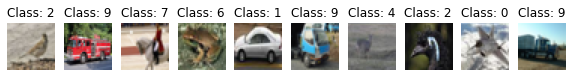

In [10]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

In [12]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [13]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [14]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
        
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [16]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 1.515725
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.769830
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.728023
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.452494
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.612920
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 2.173655
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.743832
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.484325

[EPOCH: 1], 	Test Loss: 0.0503, 	Test Accuracy: 41.15 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.326134
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.436932
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.334441
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.608863
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.629258
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.461289
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.542437
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 2.012601

[EPOCH: 2], 	Test Loss: 0.0483, 	Test Accuracy: 44.84 % 

Train Epoch: 3